# Medical Diagnosis Prediction System

### Importing necessary Python tools

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

import matplotlib.pyplot as plt

### Reading head of CSV to verify import

In [2]:
df = pd.read_csv("Disease_symptom_and_patient_profile_dataset.csv")
df.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,Outcome Variable
0,Influenza,Yes,No,Yes,Yes,19,Female,Low,Normal,Positive
1,Common Cold,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
2,Eczema,No,Yes,Yes,No,25,Female,Normal,Normal,Negative
3,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive
4,Asthma,Yes,Yes,No,Yes,25,Male,Normal,Normal,Positive


### Converting the yes/no symptom features to binary 1 or 0

In [3]:
binary_cols = ["Fever", "Cough", "Fatigue", "Difficulty Breathing"]

for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

### Handling caregorical variables with one-hot encoding

In [4]:
categorical_cols = ["Gender", "Blood Pressure", "Cholesterol Level"]

df_encoded = pd.get_dummies(df, columns=categorical_cols)
df_encoded.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Outcome Variable,Gender_Female,Gender_Male,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Cholesterol Level_High,Cholesterol Level_Low,Cholesterol Level_Normal
0,Influenza,1,0,1,1,19,Positive,True,False,False,True,False,False,False,True
1,Common Cold,0,1,1,0,25,Negative,True,False,False,False,True,False,False,True
2,Eczema,0,1,1,0,25,Negative,True,False,False,False,True,False,False,True
3,Asthma,1,1,0,1,25,Positive,False,True,False,False,True,False,False,True
4,Asthma,1,1,0,1,25,Positive,False,True,False,False,True,False,False,True


## Going to run 2 models, one to predict if disease is present, and the other to predict the most probable disease.

### Preparing x1/y1, dropping disease column to run first prediction model of if disease positive likelyhood

In [5]:
X1 = df_encoded.drop(columns=["Outcome Variable", "Disease"])
y1 = df_encoded["Outcome Variable"].map({"Positive": 1, "Negative": 0})

### Splitting the train and test

In [6]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, test_size=0.3, stratify=y1, random_state=42
)

### Building and training the random forest model

In [7]:
rf_outcome = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf_outcome.fit(X1_train, y1_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

### Predict and evaluate model with classification report

In [8]:
y1_pred = rf_outcome.predict(X1_test)
y1_proba = rf_outcome.predict_proba(X1_test)[:, 1]

print("Outcome Model Accuracy:", accuracy_score(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

Outcome Model Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.77      0.82      0.79        49
           1       0.83      0.79      0.81        56

    accuracy                           0.80       105
   macro avg       0.80      0.80      0.80       105
weighted avg       0.80      0.80      0.80       105



### Starting model 2 to predict disease of positive cases

In [9]:
df_pos = df_encoded[df_encoded["Outcome Variable"] == "Positive"].copy()

### Removing rare diseases of frequency < 3

In [10]:
disease_counts = df_pos["Disease"].value_counts()
keep_diseases = disease_counts[disease_counts >= 3].index

df_pos = df_pos[df_pos["Disease"].isin(keep_diseases)].reset_index(drop=True)

### Preparing x2/y2, dropping outcome column to run second prediction model of what disease is most likely from dataset

In [11]:
X2 = df_pos.drop(columns=["Disease", "Outcome Variable"])
y2 = df_pos["Disease"]

### Splitting the train and test

In [12]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, stratify=y2, random_state=42
)

### Building and training the random forest model

In [13]:
rf_disease = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf_disease.fit(X2_train, y2_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

### Evaluate the model with a classification report

In [14]:
y2_pred = rf_disease.predict(X2_test)
print(classification_report(y2_test, y2_pred))

                         precision    recall  f1-score   support

    Alzheimer's Disease       0.50      1.00      0.67         1
      Anxiety Disorders       0.00      0.00      0.00         1
                 Asthma       0.80      0.80      0.80         5
             Bronchitis       1.00      0.50      0.67         2
Coronary Artery Disease       0.00      0.00      0.00         1
             Depression       0.00      0.00      0.00         1
               Diabetes       0.00      0.00      0.00         1
                 Eczema       0.00      0.00      0.00         1
        Gastroenteritis       0.00      0.00      0.00         1
           Hypertension       0.00      0.00      0.00         2
        Hyperthyroidism       0.20      1.00      0.33         1
         Hypothyroidism       0.50      1.00      0.67         1
              Influenza       1.00      0.50      0.67         2
           Liver Cancer       0.00      0.00      0.00         1
               Migraine 

C:\Users\maxsc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maxsc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maxsc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Saving list of feature column names for model 1(x1) and model 2(x2) into variables for later reference to which columns each model used

In [15]:
# for Model 1 (Outcome model)
outcome_columns = X1.columns

# for Model 2 (Disease model on positives)
positive_disease_columns = X2.columns

### Creating and showing feature importance plot for the positive/negative outcome model

#### This shows which variables were most useful for the Random Forest model when predicting a positive or negative outcome

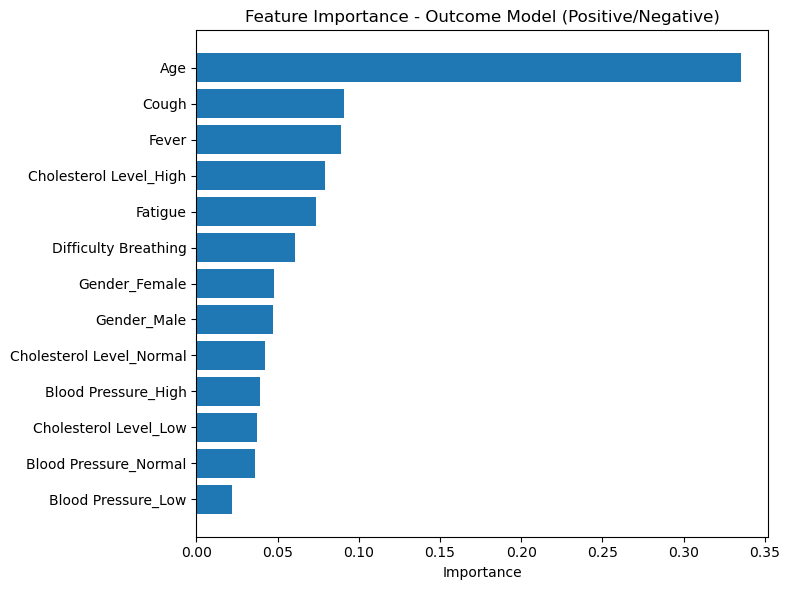

In [16]:
# get importances and sort them
importances = rf_outcome.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X1.columns

# plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance - Outcome Model (Positive/Negative)")
plt.tight_layout()
plt.show()

### Creating and showing confusion matrix for the disease prediction model based on positive outcomes

#### This confusion matrix shows how often each disease was correctly or incorrectly predicted by the model

<Figure size 1000x800 with 0 Axes>

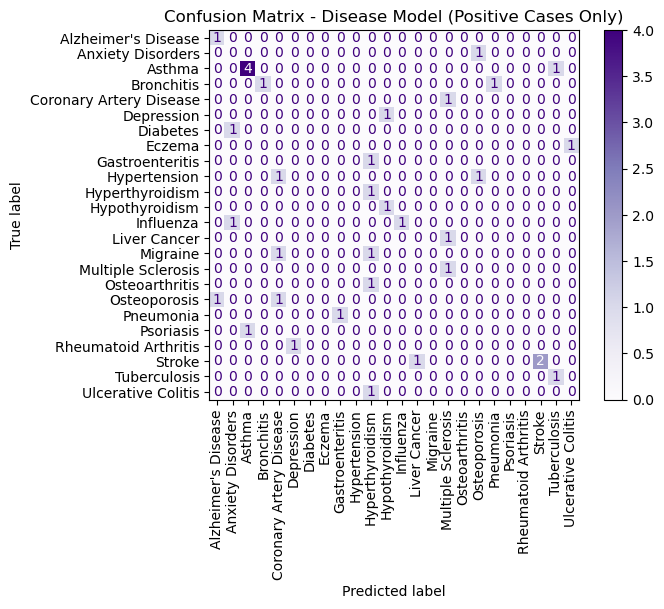

In [17]:
# predict on test set
y2_pred = rf_disease.predict(X2_test)

# compute confusion matrix
cm2 = confusion_matrix(y2_test, y2_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=rf_disease.classes_)

# plot
plt.figure(figsize=(10,8))
disp2.plot(cmap="Purples", values_format='d', xticks_rotation=90)
plt.title("Confusion Matrix - Disease Model (Positive Cases Only)")
plt.show()

### Creating and showing ROC curve to show positive/non-postive models ability to discriminate outcome

#### This shows how well the Random Forest model seperates positive vs negative outcomes across all threshold, the high AUC score shows high sensitivity, and low false positives

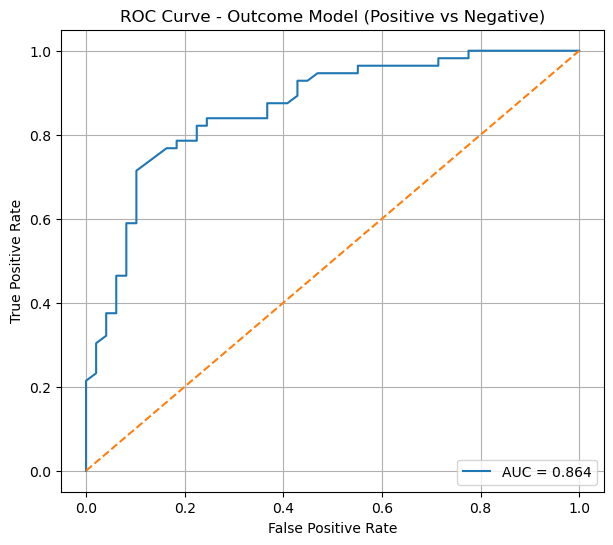

In [18]:
# get predicted probabilities for the positive class
y1_proba = rf_outcome.predict_proba(X1_test)[:, 1]

# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y1_test, y1_proba)
auc = roc_auc_score(y1_test, y1_proba)

# plot
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # diagonal = random
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Outcome Model (Positive vs Negative)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### User input function

In [19]:
def get_patient_input(outcome_columns):
    print("Please answer the following questions about your symptoms.\n")

    data = {}

    # --- binary symptoms questions ---
    def ask_yes_no(question):
        ans = input(question + " (yes/no): ").strip().lower()
        return 1 if ans in ["yes", "y", "1"] else 0

    data["Fever"] = ask_yes_no("Do you have a fever?")
    data["Cough"] = ask_yes_no("Do you have a cough?")
    data["Fatigue"] = ask_yes_no("Are you feeling fatigued?")
    data["Difficulty Breathing"] = ask_yes_no("Are you experiencing difficulty breathing?")

    # --- age question ---
    age = input("What is your age? ")
    data["Age"] = int(age)

    # --- gender question with one-hot enc---
    gender = input("What is your gender? (male/female): ").strip().lower()
    for g in ["Male", "Female"]:
        col = f"Gender_{g}"
        if col in outcome_columns:
            data[col] = 1 if gender == g.lower() else 0

    # --- blood pressure question with one-hot enc---
    bp = input("What is your blood pressure? (low/normal/high): ").strip().lower()
    for level in ["Low", "Normal", "High"]:
        col = f"Blood Pressure_{level}"
        if col in outcome_columns:
            data[col] = 1 if bp == level.lower() else 0

    # --- cholesterol question with one-hot enc ---
    chol = input("What is your cholesterol level? (low/normal/high): ").strip().lower()
    for level in ["Low", "Normal", "High"]:
        col = f"Cholesterol Level_{level}"
        if col in outcome_columns:
            data[col] = 1 if chol == level.lower() else 0

    return data

### Function for taking user inputs, running through outcome model to predict positive or negative, and if positive runs disease model to return most likely disease.

In [20]:
def predict_patient(symptom_dict, rf_outcome, rf_disease, outcome_columns, positive_disease_columns):
    
    # creating dataframe with 1 row in the correct column order
    user_df = pd.DataFrame([symptom_dict])

    # add missing columns as 0 for one-hot encoded categories
    for col in outcome_columns:
        if col not in user_df.columns:
            user_df[col] = 0

    user_df = user_df[outcome_columns]
    
    # ---- PREDICT OUTCOME ----
    outcome_proba = rf_outcome.predict_proba(user_df)[0][1]
    outcome_pred = "Positive" if outcome_proba >= 0.5 else "Negative"

    result = {
        "Outcome Prediction": outcome_pred,
        "Outcome Probability": round(outcome_proba, 3)
    }

    if outcome_pred == "Negative":
        return result  # No disease prediction

    # ---- PREDICT DISEASE ----
    user_df_pos = pd.DataFrame([symptom_dict])
    for col in positive_disease_columns:
        if col not in user_df_pos.columns:
            user_df_pos[col] = 0
    user_df_pos = user_df_pos[positive_disease_columns]
    
    disease_proba = rf_disease.predict_proba(user_df_pos)[0]
    classes = rf_disease.classes_

    # finding top disease
    top_index = disease_proba.argmax()
    top_disease = classes[top_index]
    top_prob = disease_proba[top_index]

    result["Predicted Disease"] = top_disease
    result["Disease Probability"] = round(top_prob, 3)

    return result

### Function for runnning models and printing results 

In [21]:
def interactive_prediction():
    # get user input one at a time
    patient_dict = get_patient_input(outcome_columns)

    # running through 2 model pipeline
    result = predict_patient(
        symptom_dict=patient_dict,
        rf_outcome=rf_outcome,
        rf_disease=rf_disease,
        outcome_columns=outcome_columns,
        positive_disease_columns=positive_disease_columns
    )

    # print results
    print("\n--- Prediction Result ---")
    print(f"Outcome Prediction : {result['Outcome Prediction']}")
    print(f"Outcome Probability (Greater than .500 is positive): {result['Outcome Probability']}")

    if result["Outcome Prediction"] == "Positive":
        print(f"Predicted Disease  : {result['Predicted Disease']}")
        print(f"Probability of which disease: {result['Disease Probability']}")

### Running prediction 

In [ ]:
interactive_prediction()

Please answer the following questions about your symptoms.

